# NN with Complex function 

In [1]:
import autograd.numpy as np 
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression, Lasso, SGDRegressor
from sklearn.neural_network import MLPRegressor
import pandas as pd
from numpy import asarray
from matplotlib.table import Table

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def identity(x):
    return x

def identity_derivative(x):
    return np.ones_like(x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)
    
def elu(x, alpha=1.0):
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, elu(x, alpha) + alpha)

def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

def mse_der(predictions, targets):
    return 2 * (predictions - targets) / targets.shape[0]

def r2_score(predictions, targets):
    ss_total = np.sum((targets - np.mean(targets)) ** 2)
    ss_residual = np.sum((targets - predictions) ** 2)
    return 1 - (ss_residual / ss_total)

def create_layers_batch(network_input_size, layer_output_sizes): 
    layers = []
    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(i_size, layer_output_size) * np.sqrt(2 / (i_size + layer_output_size))
        b = np.zeros(layer_output_size)
        layers.append((W, b))
        i_size = layer_output_size
    return layers

def feed_forward_batch(inputs, layers, activation_funcs):
    a = inputs
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = (a @ W) + b
        a = activation_func(z)
    return a

def feed_forward_saver_batch(inputs, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = inputs  
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a @ W + b  
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a 

def backpropagation_batch(inputs, layers, activation_funcs, targets, activation_ders, cost_der):
    batch_size = inputs.shape[0]
    layer_inputs, zs, predict = feed_forward_saver_batch(inputs, layers, activation_funcs)
    layer_grads = [() for _ in layers]

    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]
        
        if i == len(layers) - 1:
            dC_da = cost_der(predict, targets)
        else:
            (W, b) = layers[i + 1][:2]
            dC_da = dC_dz @ W.T 
        
        dC_dz = dC_da * activation_der(z)
        dC_dW = dC_dW = layer_input.T @ dC_dz / batch_size
        dC_db = np.mean(dC_dz, axis=0)
        
        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

def train_nn(inputs, targets, val_inputs, val_targets, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size):
    num_samples = inputs.shape[0]
    training_metrics = {'mse': [], 'r2': []}
    validation_metrics = {'mse': [], 'r2': []}

    for epoch in range(epochs):
        # Shuffle the training data
        permutation = np.random.permutation(num_samples)
        inputs_shuffled = inputs[permutation]
        targets_shuffled = targets[permutation]

        # Training over batches
        for i in range(0, num_samples, batch_size):
            input_batch = inputs_shuffled[i:i + batch_size]
            target_batch = targets_shuffled[i:i + batch_size]

            # Backpropagation
            layer_grads = backpropagation_batch(input_batch, layers, activation_funcs, target_batch, activation_ders, mse_der)

            # Update weights and biases
            for j, (dC_dW, dC_db) in enumerate(layer_grads):
                W, b = layers[j]
                layers[j] = (W - learning_rate * dC_dW, b - learning_rate * dC_db)
                

        # Calculate metrics on training set
        predictions_train = feed_forward_batch(inputs, layers, activation_funcs)
        mse_train = mse(predictions_train, targets)
        r2_train = r2_score(predictions_train, targets)
        training_metrics['mse'].append(mse_train)
        training_metrics['r2'].append(r2_train)

        # Calculate metrics on validation set
        predictions_val = feed_forward_batch(val_inputs, layers, activation_funcs)
        mse_val = mse(predictions_val, val_targets)
        r2_val = r2_score(predictions_val, val_targets)
        validation_metrics['mse'].append(mse_val)
        validation_metrics['r2'].append(r2_val)

        # Print the results for the current epoch
        #print(f"Epoch {epoch + 1}, Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}, Val MSE: {mse_val:.4f}, Val R²: {r2_val:.4f}")

    return layers, training_metrics, validation_metrics

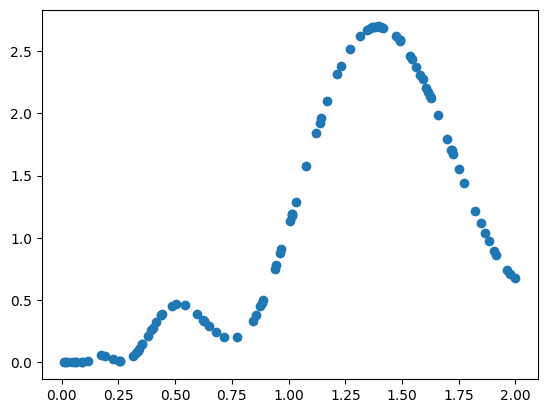

In [2]:
# Make data
np.random.seed(22)
n = 100
X = 2 * np.random.rand(n, 1)

#y = np.sin(2 *X) + 3 * np.log(np.abs(X) + 1) + 4*X**3 + np.random.randn(n, 1)
y= np.sin(X**2) * np.exp(-X / 10)+ (1/3) * X**3 + np.log(1 + X**2)* np.sin(np.log(X**6)) 
#+ np.random.randn(n, 1)
plt.scatter(X,y)
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Splitting into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=32)

## NN with SGD 

Val MSE: 0.0244, Val R²: 0.9563


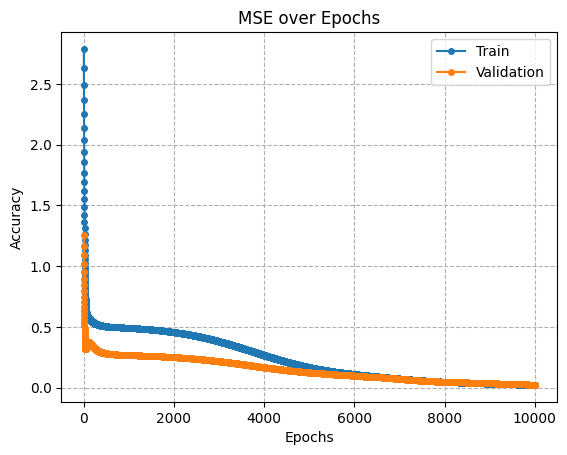

In [3]:
np.random.seed(67)
layers = create_layers_batch(network_input_size=1, layer_output_sizes=[50, 1])

# Activation functions
activation_funcs = [ relu, identity]
activation_ders = [relu_derivative,identity_derivative]

learning_rate = 0.1
epochs = 10000
batch_size = 32

# Training
trained_layers, training_metrics, validation_metrics =  train_nn(X_train, y_train, X_val, y_val, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size)
print(f"Val MSE: {validation_metrics['mse'][-1]:.4f}, Val R²: {validation_metrics['r2'][-1]:.4f}")

plt.plot(range(1, len(training_metrics["mse"]) + 1), training_metrics["mse"], label="Train", marker='o', markersize=4)
plt.plot(range(1, len(validation_metrics["mse"]) + 1), validation_metrics["mse"], label="Validation", marker='o', markersize=4)
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, which="both", linestyle='--')
plt.show()

# con 2,3,3 nodi per layer, sig*3 = 102.2983, relu+sig*2= 106, sig+relu*2= 1.9641, relu*3= 105.6510 , leaky_relu*3= 27
# con 4,8,5 nodi per layer sig*3 = 66.6183, relu+sig*2= 8.9852, sig+relu*2= 1.4610, relu*3= 2.6307

#con 3 e 5 nodi per layer, sigmoid + relu=1.8646, relu + sigmoid = 6.39, relu+relu= 3.0267, sigmoid+sigmoid= 10.6566
#con 5 e 7 nodi per layer, sigmoid+ relu=1.8641 , relu+sigmoid= 6.3909,   relu+relu= 3.6196, sigmoid+sigmoid= 13.9868
#con 8,6 nodi per layer relu*2 = 2.25268, sig*2= 8.6945, relu*sig= 5.0439, sig*relu= 1.76
#con 8,8 nodi per layer relu*2 = 2.1330 , sig*2= 7.6945, relu*sig= 6.0228, sig*relu= 2.8488
#con 10,15 nodi per layer relu*2= 1.5835, sig*2= 4.0025, relu*sig= 3.5935, sig*relu= 1.7251
#con 15,10 nodi per layer relu*2= 1.6431, sig*2= 4.0792, relu*sig= 4.0319, sig*relu= 2.2598

#con 20 relu= 2.2431, sig= 10.1016
#con 13 relu= 1.9714, sig= 9.4237
#con 8 relu= 2.4200, sig= 9.3644
#con 4 relu= 2.4438, sig= 12.3042
#con 2 relu= 105.6510, sig= 24.3988

#con 3,3,2,3,3, solo sig=106, sig relu relu relu sig = 106
# con 3,4,3,4,5, solo sig= 106, sig relu sig relu sig= 10.7785
# con 5,8,4,8,6 solo sig=106, sig relu sig relu sig=106.1822

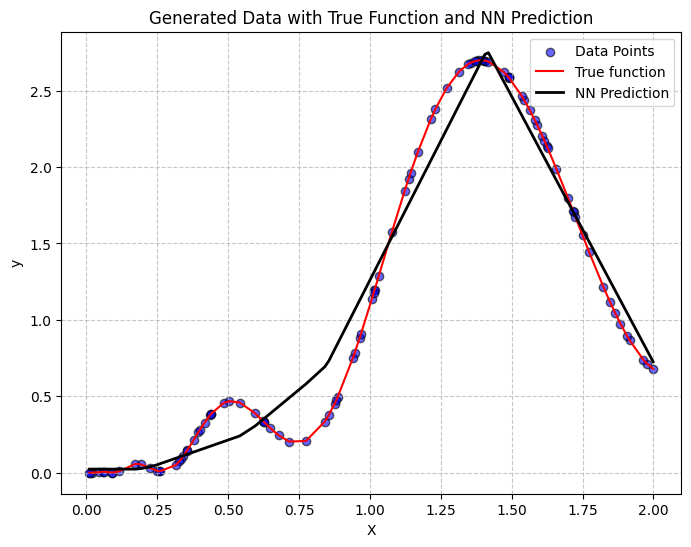

In [4]:
# Predict on the sorted input data
X_sorted = np.sort(X, axis=0)
y_pred = feed_forward_batch(X_sorted, trained_layers, activation_funcs)

# Plot the data points
sorted_index = np.argsort(X, axis = 0).ravel()
X_sorted = X[sorted_index]
y_sorted = y[sorted_index]
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', alpha=0.6, edgecolor='k', label='Data Points')
plt.plot(X_sorted, y_sorted, color='red', label='True function')

# Plot the predicted curve from the neural network
plt.plot(X_sorted, y_pred, color='black', linewidth=2, label='NN Prediction')

# Set plot details
plt.title('Generated Data with True Function and NN Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

## NN with SGD SCIKIT

In [5]:
# Create and train the MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(50,30),  # Single hidden layer with 10 neurons (like before)
    activation='logistic',     # 'logistic' corresponds to the sigmoid function
    solver='sgd',              # Stochastic Gradient Descent optimizer
    learning_rate_init=0.1,  # Initial learning rate
    max_iter=10000,              # Number of epochs
    batch_size=32,             # Minibatch size
    random_state=32)

# Fit the model to the training data
mlp.fit(X_train, y_train.ravel())

# Make predictions
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Val MSE: {mse_val:.4f}, Val R²: {r2_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

Train MSE: 0.4287, Train R²: -173.0650
Val MSE: 0.3013, Val R²: -31.5088
Test MSE: 0.2360, Test R²: -57.6033


## NN ADAM MANUALLY

In [6]:
# ADAM
def train_nn_adam(X_train, y_train, X_val, y_val, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size, decay1=0.9, decay2=0.999, epsilon=1e-8):
    num_samples = X_train.shape[0]
    training_metrics = {'mse': [], 'r2': []}
    validation_metrics = {'mse': [], 'r2': []}
    
    # Initialize first and second moment vectors for weights and biases
    m_W = [np.zeros_like(W) for W, b in layers]
    v_W = [np.zeros_like(W) for W, b in layers]
    m_b = [np.zeros_like(b) for W, b in layers]
    v_b = [np.zeros_like(b) for W, b in layers]

    for epoch in range(epochs):
        permutation = np.random.permutation(num_samples)
        X_shuffled = X_train[permutation]
        y_shuffled = y_train[permutation]

        for i in range(0, num_samples, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            # Backpropagation to get the gradients
            layer_grads = backpropagation_batch(X_batch, layers, activation_funcs, y_batch, activation_ders, mse_der)
            
            for j, (dC_dW, dC_db) in enumerate(layer_grads):
                # Update biased first moment estimate for weights and biases
                m_W[j] = decay1 * m_W[j] + (1 - decay1) * dC_dW
                m_b[j] = decay1 * m_b[j] + (1 - decay1) * dC_db
                
                # Update biased second moment estimate for weights and biases
                v_W[j] = decay2 * v_W[j] + (1 - decay2) * (dC_dW ** 2)
                v_b[j] = decay2 * v_b[j] + (1 - decay2) * (dC_db ** 2)
                
                # Correct bias for first moment
                m_W_hat = m_W[j] / (1 - decay1 ** (epoch + 1))
                m_b_hat = m_b[j] / (1 - decay1 ** (epoch + 1))
                
                # Correct bias for second moment
                v_W_hat = v_W[j] / (1 - decay2 ** (epoch + 1))
                v_b_hat = v_b[j] / (1 - decay2 ** (epoch + 1))
                
                # Update weights and biases with Adam formula
                W, b = layers[j]
                W -= learning_rate * m_W_hat / (np.sqrt(v_W_hat) + epsilon)
                b -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + epsilon)
                layers[j] = (W, b)
        
        # Calculate metrics on the training set
        predictions_train = feed_forward_batch(X_train, layers, activation_funcs)
        mse_train = mse(predictions_train, y_train)
        r2_train = r2_score(predictions_train, y_train)
        training_metrics['mse'].append(mse_train)
        training_metrics['r2'].append(r2_train)

        # Calculate metrics on the validation set
        predictions_val = feed_forward_batch(X_val, layers, activation_funcs)
        mse_val = mse(predictions_val, y_val)
        r2_val = r2_score(predictions_val, y_val)
        validation_metrics['mse'].append(mse_val)
        validation_metrics['r2'].append(r2_val)

        # Print progress
        #print(f"Epoch {epoch + 1}, Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}, Val MSE: {mse_val:.4f}, Val R²: {r2_val:.4f}")

    return layers, training_metrics, validation_metrics
# Layers initialization with a simple architecture
layers = create_layers_batch(network_input_size=1, layer_output_sizes=[50, 1])

# Activation functions
activation_funcs = [relu, identity]
activation_ders = [relu_derivative, identity_derivative]

# Training parameters
learning_rate = 0.1
epochs = 10000 
batch_size = 32
random_state=32

#print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")
trained_layers, training_metrics, validation_metrics = train_nn_adam(X_train, y_train, X_val, y_val, layers, activation_funcs, activation_ders, learning_rate, epochs, batch_size)
print(f"Val MSE: {validation_metrics['mse'][-1]:.4f}, Val R²: {validation_metrics['r2'][-1]:.4f}")

# Testing on the test set
predictions_test = feed_forward_batch(X_test, trained_layers, activation_funcs)
mse_test = mse(predictions_test, y_test)
r2_test = r2_score(predictions_test, y_test)

print(f"Test MSE: {mse_test:.4f}, Test R²: {r2_test:.4f}")

Val MSE: 0.0142, Val R²: 0.9746
Test MSE: 0.0134, Test R²: 0.9856


### NN ADAM WITH SCIKIT

In [7]:
# Define the MLP regressor with Adam optimizer
mlp = MLPRegressor(
    hidden_layer_sizes=(50,30,30,40),  # One hidden layer with 10 neurons
    activation='logistic',         # Activation function for hidden layers
    solver='adam',             # Using Adam as optimizer
    learning_rate_init=0.1,  # Initial learning rate
    max_iter=10000,              # Number of epochs
    batch_size=32,
    random_state=32
)

# Train the model
mlp.fit(X_train, y_train.ravel())

# Evaluate the model on training and validation sets
y_train_pred = mlp.predict(X_train)
y_val_pred = mlp.predict(X_val)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

#print(f"Train MSE: {mse_train:.4f}, Train R²: {r2_train:.4f}")
print(f"Validation MSE: {mse_val:.4f}, Validation R²: {r2_val:.4f}")

Validation MSE: 0.7700, Validation R²: -23596830532.7324
